# WeatherPy
----

## Analysis

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time

import random as random
import gmaps
from pprint import pprint
import pycountry
from IPython.display import (Image, HTML)
import logging
import math


# Keys
from api_config import (key_openweathermap, key_gmaps)

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
ofile_city_weather_data = "Results/city_weather_data.csv"

# Logging File
ofile_progress_log = "Results/progress.log"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List
* 500 cities selected at random latitudes and longitudes from the entire range of lat./long. values could still result in a less than representative sample of cities in the world.
* To mitigate this, a uniform grid of latitude and longitude points will be defined.  Then a set of random latitude and longitude points will be selected about each of these points, ensuring that our sample of cities will encompass all lat/long areas.
* Citypy will then be used to identify cities near each of the sample points that have a population of over 500.
* Granularity of the uniform lat/long grid will be adjusted so that approx 500 cities are selected in the random sampling.

## Approach
1. Set the granularity (grid_gran) of the uniform latitude / longitude grid; start with grid_gran=10 degrees (which yields 648 grid areas)
    * Number of latitude grid sections = (180 - [-180]) / grid_gran = 360 / grid_gran
    * Number of longitude grid sections = (90 - [-90]) / grid_gran = 180 / grid_gran
    * Number of lat/long grid areas = n_grid_areas = (360 * 180) / (grid_gran^2)

1. Generate a grid of latitude and longitude numbers for the entire world
1. For each lat/long grid point, generate a small set of random sample of lat/long points from within the grid_gran by grid_gran area about the lat/long grid point.
1. For each random sample lat/long point, use citipy to determine the nearest city. If the citipy nearest city is within the grid_gran by grid_gran area surrounding the sample lat/long point, then include it in our list of cities.  Otherwise exclude that city from list of cities -- it is not representative of the sample lat/long point.
1. Manually check the tally of cities in the city list to see if we have about 500 cities.  If not, adjust the granularity (grid_gran) as appropriate.  (If we have way too many grid areas and resultant cities, then may need to just perform a random sample of the city list.)

In [2]:
# Limit latitude to allowable values
def limit_lat(alat):
    return max(min(alat,90),-90)

# Limit longitude to allowable values
def limit_long(along):
    return max(min(along,180),-180)

# Generate a random lat/long point within each grid area
def random_latlong(gp,gg):
    # Generate a random lat/long point 
    #  that is within (gg) by (gg) area around grid lat/long point (gp)
    r_lat = limit_lat(gp[0] + random.uniform(-gg/2.0, +gg/2.0))
    r_long = limit_long(gp[1] + random.uniform(-gg/2.0, +gg/2.0))
    
    return (r_lat, r_long)

# Check if a specified lat/long point is within a grid area of a reference lat/long point
def check_latlong(gp,rp,gg):
    # If the specified grid point (gp) is within
    #  (gg) by (gg) area around the reference lat/long point (rp),
    #  then return True, otherwise False
    if (abs(gp[0] - rp[0]) <= gg/2.0) and (abs(gp[1] - rp[1]) <= gg/2.0):
        return True
    else:
        return False

# Function to prep a weather icon url for display with HTML formating
def prep_image(ipath):
    return '<img src="' + ipath + '" />'


In [3]:
# Grid granularity (degrees of latitude or longitude)
grid_gran = 7

# Establish the grid as a list of lat/long tuples
grid_latlong = [( limit_lat(round(lat,2)), limit_long(round(long,2)) )
                for lat in np.arange(-90.0,90.0+grid_gran,grid_gran)
                for long in np.arange(-180.0, 180.0+grid_gran, grid_gran)
               ]
n_grid_areas = len(grid_latlong)
n_grid_areas

1431

In [4]:
# Initial the list of cities
cities_df = pd.DataFrame(columns = ['City Name',
                                    'Country Name', 'Country Official Name', 'Country Code', 
                                    'Target Lat', 'Target Long', 'Grid Lat', 'Grid Long'])

# Loop through all grid points
for gp in grid_latlong:
    # For grid point, select a random lat/long from
    #  within the (grid_gran) x (grid_gran) area around the grid point
    rp = random_latlong(gp, grid_gran)
    
    # print(f"Grid Point: {gp}, Random Point: {rp}")
    
    # Get the nearest city from citipy
    n_city = citipy.nearest_city(rp[0], rp[1])
    
    # Get the name of the city
    city_name = n_city.city_name.title()

    # Get the 2-letter country code for the country in which this city is located
    country_code = n_city.country_code.upper()
    
    # Get the name of the country that this nearest city is in
    #   country.alpha_2 = 2-letter abbreviation of the country (i.e., country code) [key for this look-up]
    #   country.name = Common name of the country
    #   country.official_name = Official name of the country
    
    # Some country codes are not populated in the country module
    try:
        country = pycountry.countries.get(alpha_2 = country_code )
        country_name = country.name
    except:
        country_name = country_code
    
    # Some countries do not have official_name populated
    try:
        country_official_name = country.official_name
    except:
        country_official_name = country_name
    
    # At this point, the plan was to compare the actual lat/long of the city that was found
    #  to the lat/long of the grid point (gp) and to only include this city in the cities list
    #  if this city is with the (grid_gran) x (grid_gran) area around the grid point.
    # But... citipy doesn't return the actual lat/long of the nearest city, so will need to either
    #  refactor the code to provide a method of access this info or just skip it -- which I'll do for now...
    # So... add this city to the list of cities...
    
    # Check to make sure this city is not already in the list of cities
    # Note: It's ok to have dup city name as long as country is different
    if cities_df['City Name'].loc[  (cities_df['City Name'] == city_name)
                                  & (cities_df['Country Code'] == country_code) ].count() == 0:
    
        # Ok, add the city to the list of cities
        cities_df = cities_df.append({
                                    'City Name':city_name,
                                    'Country Code':country_code,
                                    'Country Name':country_name,
                                    'Country Official Name':country_official_name,
                                    'Target Lat':float(rp[0]),
                                    'Target Long':float(rp[1]),
                                    'Grid Lat':float(gp[0]),
                                    'Grid Long':float(gp[1]),
                                    }, ignore_index=True)
    

In [5]:
cities_df.dtypes

City Name                 object
Country Name              object
Country Official Name     object
Country Code              object
Target Lat               float64
Target Long              float64
Grid Lat                 float64
Grid Long                float64
dtype: object

# Get City Weather Information


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [6]:
# Prepare items needed for OpenWeatherMap API calls
owm_base_url = "http://api.openweathermap.org/data/2.5/weather?"
owm_key = "appid=" + key_openweathermap
owm_units = "units=imperial"

# Other info: Base URL for weather icon
owm_iconbase_url = "http://openweathermap.org/img/w/"
owm_icon_suffix = ".png"

# Prepare the logfile
logging.basicConfig(filename=ofile_progress_log, filemode='w', level=logging.INFO,
                    format='%(asctime)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

for ci in cities_df.index:
    # Initialize a list to hold progress information
    #  for display on console (using 'print') and log file (using 'logging.info')
    progress_info = [ f"Getting Weather Info for City #{ci}: {cities_df.loc[ci, 'City Name']} ({cities_df.loc[ci, 'Country Name']})" ]
    progress_info.append(f"> Target Lat: {cities_df.loc[ci, 'Target Lat']}, Target Long: {cities_df.loc[ci, 'Target Long']}]")
    
    # Assemble the query url for this
    owm_city = cities_df.loc[ci, 'City Name']
    owm_country_code = cities_df.loc[ci, 'Country Code']
    owm_full_url = owm_base_url + owm_key + "&" + owm_units + "&q=" + owm_city + "," + owm_country_code

    # Submit the GET request to the OpenWeatherMap API and process the JSON response
    w_response = requests.get(owm_full_url)
    w_json = w_response.json()
    
    # If the weather is not available for this city, stop processing
    if w_json['cod'] != 200:
        progress_info.append(f"> No weather data available for this city (code: {w_json['cod']}, message: {w_json['message']})\n")
        
        for p in progress_info:
            print(p)
            logging.info(p)
            
        continue

    # City weather info
    # Temperature (Fahrenheit)
    try:
        c_temp = float(w_json['main']['temp'])
    except:
        c_temp = None

    # Humidity (%)
    try:
        c_humid = float(w_json['main']['humidity'])
    except:
        c_humid = None

    # Cloudiness (%)
    try:
        c_cloud = float(w_json['clouds']['all'])
    except:
        c_cloud = None

    # Wind Speed (mph)
    try:
        c_wind_speed = float(w_json['wind']['speed'])
    except:
        c_wind_speed = None
    
    # Wind Direction (degrees)
    try:
        c_wind_dir = float(w_json['wind']['deg'])
    except:
        c_wind_dir = None

    # Actual Latitude and Longitude
    try:
        c_act_lat = float(w_json['coord']['lat'])
        c_act_long = float(w_json['coord']['lon'])
    except:
        c_act_lat = None
        c_act_long = None
    
    # Weather Description
    try:
        c_desc = w_json['weather'][0]['description']
    except:
        c_desc = None

    # Weather Icon URL
    try:
        c_icon_url = owm_iconbase_url + w_json['weather'][0]['icon'] + owm_icon_suffix
    except:
        c_icon_url = None
    
    # Just for curiosity sake, check to see if the actual lat/long is
    #  within the target lat/long grid area
    c_in_gridarea = check_latlong( (c_act_lat, c_act_long),
                                   (cities_df.loc[ci, 'Target Lat'], cities_df.loc[ci, 'Target Long']),
                                   grid_gran)
  
    # Print out a nice detailed progress message
    progress_info.append (f"> City: {w_json['name']}, Country: {w_json['sys']['country']}")
    progress_info.append (f"> Temp: {c_temp}, Humidity: {c_humid}, Clouds: {c_cloud}%")
    progress_info.append (f"> Wind: {c_wind_speed} mph at {c_wind_dir} deg")
    progress_info.append (f"> Weather Description: {c_desc}")
    progress_info.append (f"> Weather Icon: {c_icon_url}")
    progress_info.append (f"> Act. Lat: {c_act_lat}, Act. Long: {c_act_long}, In Target Grid Area: {c_in_gridarea}\n")

    for p in progress_info:
        print(p)
        logging.info(p)

    # Populate this data in the cities_df dataframe
    cities_df.loc[ci, 'Actual Lat'] = c_act_lat
    cities_df.loc[ci, 'Actual Long'] = c_act_long
    cities_df.loc[ci, 'In Target Grid Area'] = c_in_gridarea
    cities_df.loc[ci, 'Temp'] = c_temp
    cities_df.loc[ci, 'Humidity'] = c_humid
    cities_df.loc[ci, 'Cloudiness'] = c_cloud
    cities_df.loc[ci, 'Wind Speed'] = c_wind_speed
    cities_df.loc[ci, 'Wind Direction'] = c_wind_dir
    cities_df.loc[ci, 'Weather Description'] = c_desc
    cities_df.loc[ci, 'Weather Icon URL'] = c_icon_url

    #DEBUG
    #if ci>3:
    #    break
        

Getting Weather Info for City #0: Vaini (Tonga)
> Target Lat: -90.0, Target Long: -178.57431159555952]
> City: Vaini, Country: TO
> Temp: 73.4, Humidity: 94.0, Clouds: 75.0%
> Wind: 4.85 mph at 99.5038 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: -21.2, Act. Long: -175.2, In Target Grid Area: False

Getting Weather Info for City #1: Mataura (French Polynesia)
> Target Lat: -90.0, Target Long: -156.3306489581834]
> No weather data available for this city (code: 404, message: city not found)

Getting Weather Info for City #2: Rikitea (French Polynesia)
> Target Lat: -90.0, Target Long: -139.69944296144624]
> City: Rikitea, Country: PF
> Temp: 78.29, Humidity: 100.0, Clouds: 20.0%
> Wind: 11.18 mph at 67.0038 deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02d.png
> Act. Lat: -23.12, Act. Long: -134.97, In Target Grid Area: False

Getting Weather Info for City #3: Punta Arenas (Chile)
> T

Getting Weather Info for City #24: Castro (Chile)
> Target Lat: -53.7335299802519, Target Long: -102.07082304182217]
> City: Castro, Country: CL
> Temp: 55.4, Humidity: 87.0, Clouds: 90.0%
> Wind: 14.99 mph at 340.0 deg
> Weather Description: mist
> Weather Icon: http://openweathermap.org/img/w/50d.png
> Act. Lat: -42.48, Act. Long: -73.76, In Target Grid Area: False

Getting Weather Info for City #25: Arraial Do Cabo (Brazil)
> Target Lat: -55.19962036308101, Target Long: -18.75801453403345]
> City: Arraial do Cabo, Country: BR
> Temp: 86.47, Humidity: 66.0, Clouds: 20.0%
> Wind: 16.11 mph at 130.0 deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02d.png
> Act. Lat: -22.97, Act. Long: -42.02, In Target Grid Area: False

Getting Weather Info for City #26: Mahebourg (Mauritius)
> Target Lat: -56.62928585145022, Target Long: 79.53850571729781]
> City: Mahebourg, Country: MU
> Temp: 80.6, Humidity: 83.0, Clouds: 20.0%
> Wind: 7.38 mph at 136.504 deg
> 

Getting Weather Info for City #46: Otane (New Zealand)
> Target Lat: -41.001545660892056, Target Long: 177.6239258403196]
> City: Otane, Country: NZ
> Temp: 53.54, Humidity: 90.0, Clouds: 8.0%
> Wind: 2.51 mph at 296.504 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/02n.png
> Act. Lat: -39.89, Act. Long: 176.62, In Target Grid Area: True

Getting Weather Info for City #47: Lebu (Chile)
> Target Lat: -33.70878951245961, Target Long: -103.71316064406228]
> City: Lebu, Country: CL
> Temp: 58.53, Humidity: 96.0, Clouds: 0.0%
> Wind: 12.12 mph at 206.004 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01d.png
> Act. Lat: -37.62, Act. Long: -73.65, In Target Grid Area: False

Getting Weather Info for City #48: Constitucion (Chile)
> Target Lat: -33.21887487421186, Target Long: -77.64494844569835]
> City: Constitucion, Country: CL
> Temp: 62.13, Humidity: 78.0, Clouds: 0.0%
> Wind: 15.37 mph at 220.504 deg
> Weather D

Getting Weather Info for City #70: Vallenar (Chile)
> Target Lat: -28.92273473001061, Target Long: -71.63759355843285]
> City: Vallenar, Country: CL
> Temp: 75.0, Humidity: 70.0, Clouds: 64.0%
> Wind: 2.91 mph at 279.504 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: -28.58, Act. Long: -70.76, In Target Grid Area: True

Getting Weather Info for City #71: Jujuy (Argentina)
> Target Lat: -24.28738068365676, Target Long: -65.3636819884657]
> No weather data available for this city (code: 404, message: city not found)

Getting Weather Info for City #72: Pozo Colorado (Paraguay)
> Target Lat: -23.80153919784216, Target Long: -59.84377974214169]
> City: Pozo Colorado, Country: PY
> Temp: 91.65, Humidity: 63.0, Clouds: 64.0%
> Wind: 10.63 mph at 0.00384521 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: -23.49, Act. Long: -58.8, In Target Grid Area: True

Getting Weather 

Getting Weather Info for City #93: Pisco (Peru)
> Target Lat: -23.236300897222378, Target Long: -95.01683712275783]
> City: Pisco, Country: PE
> Temp: 71.6, Humidity: 30.0, Clouds: 0.0%
> Wind: 10.29 mph at 290.0 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01d.png
> Act. Lat: -13.71, Act. Long: -76.2, In Target Grid Area: False

Getting Weather Info for City #94: Punta De Bombon (Peru)
> Target Lat: -17.562822535382374, Target Long: -71.94755601058277]
> City: Punta de Bombon, Country: PE
> Temp: 69.6, Humidity: 100.0, Clouds: 88.0%
> Wind: 8.28 mph at 163.504 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: -17.17, Act. Long: -71.79, In Target Grid Area: True

Getting Weather Info for City #95: Uyuni (Bolivia, Plurinational State of)
> Target Lat: -19.8421595793465, Target Long: -68.24839398054539]
> City: Uyuni, Country: BO
> Temp: 55.2, Humidity: 92.0, Clouds: 48.0%
> Wind: 5.82 mp

Getting Weather Info for City #115: Mount Isa (Australia)
> Target Lat: -22.866025118009123, Target Long: 140.6316954725505]
> City: Mount Isa, Country: AU
> Temp: 89.6, Humidity: 31.0, Clouds: 0.0%
> Wind: 13.87 mph at 90.0 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: -20.73, Act. Long: 139.49, In Target Grid Area: True

Getting Weather Info for City #116: Bowen (Australia)
> Target Lat: -17.48591665280525, Target Long: 149.13342304423745]
> City: Bowen, Country: AU
> Temp: 75.2, Humidity: 83.0, Clouds: 90.0%
> Wind: 9.17 mph at 120.0 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: -20.01, Act. Long: 148.25, In Target Grid Area: True

Getting Weather Info for City #117: Poum (New Caledonia)
> Target Lat: -22.91442450192076, Target Long: 159.4629408165326]
> City: Poum, Country: NC
> Temp: 77.39, Humidity: 100.0, Clouds: 0.0%
> Wind: 19.91 mph at 114.004 deg
> Weat

Getting Weather Info for City #139: Matiri (Tanzania, United Republic of)
> Target Lat: -10.201449543558194, Target Long: 34.6875064335636]
> City: Matiri, Country: TZ
> Temp: 71.54, Humidity: 100.0, Clouds: 20.0%
> Wind: 3.4 mph at 131.004 deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02n.png
> Act. Lat: -10.75, Act. Long: 34.9, In Target Grid Area: True

Getting Weather Info for City #140: Mocambique (Mozambique)
> Target Lat: -15.225094536780887, Target Long: 43.25071272472705]
> No weather data available for this city (code: 404, message: city not found)

Getting Weather Info for City #141: Sambava (Madagascar)
> Target Lat: -11.265905463841214, Target Long: 54.371740261226265]
> City: Sambava, Country: MG
> Temp: 83.42, Humidity: 100.0, Clouds: 88.0%
> Wind: 11.41 mph at 142.004 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: -14.27, Act. Long: 50.17, In Target Grid Area: False



Getting Weather Info for City #164: Ilebo (Congo, The Democratic Republic of the)
> Target Lat: -3.6246164343253735, Target Long: 21.24668659293338]
> City: Ilebo, Country: CD
> Temp: 77.93, Humidity: 84.0, Clouds: 64.0%
> Wind: 3.36 mph at 279.004 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: -4.33, Act. Long: 20.59, In Target Grid Area: True

Getting Weather Info for City #165: Kahama (Tanzania, United Republic of)
> Target Lat: -4.218759962659949, Target Long: 32.31865089482146]
> City: Kahama, Country: TZ
> Temp: 67.71, Humidity: 89.0, Clouds: 12.0%
> Wind: 2.91 mph at 261.004 deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02n.png
> Act. Lat: -3.83, Act. Long: 32.6, In Target Grid Area: True

Getting Weather Info for City #166: Utete (Tanzania, United Republic of)
> Target Lat: -8.673720240690557, Target Long: 38.06969895109715]
> City: Utete, Country: TZ
> Temp: 80.18, Humidity: 7

Getting Weather Info for City #186: Inirida (Colombia)
> Target Lat: 3.20769205236856, Target Long: -66.69565684130365]
> City: Inirida, Country: CO
> Temp: 85.35, Humidity: 76.0, Clouds: 12.0%
> Wind: 0.22 mph at 306.004 deg
> Weather Description: light rain
> Weather Icon: http://openweathermap.org/img/w/10d.png
> Act. Lat: 3.87, Act. Long: -67.92, In Target Grid Area: True

Getting Weather Info for City #187: Manaus (Brazil)
> Target Lat: -1.1185158136677535, Target Long: -59.78638678614476]
> City: Manaus, Country: BR
> Temp: 85.96, Humidity: 66.0, Clouds: 40.0%
> Wind: 5.82 mph at 90.0 deg
> Weather Description: scattered clouds
> Weather Icon: http://openweathermap.org/img/w/03d.png
> Act. Lat: -3.13, Act. Long: -59.98, In Target Grid Area: True

Getting Weather Info for City #188: Terra Santa (Brazil)
> Target Lat: -2.0436965027567555, Target Long: -56.543950493029854]
> City: Terra Santa, Country: BR
> Temp: 82.88, Humidity: 90.0, Clouds: 36.0%
> Wind: 4.92 mph at 18.5038 deg
>

Getting Weather Info for City #208: Tarakan (Indonesia)
> Target Lat: 1.7895149699328208, Target Long: 119.6682778996333]
> City: Tarakan, Country: ID
> Temp: 81.66, Humidity: 97.0, Clouds: 64.0%
> Wind: 4.63 mph at 99.0038 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 3.3, Act. Long: 117.63, In Target Grid Area: True

Getting Weather Info for City #209: Sorong (Indonesia)
> Target Lat: 3.3914802635382184, Target Long: 131.0231865604187]
> City: Sorong, Country: ID
> Temp: 76.67, Humidity: 100.0, Clouds: 44.0%
> Wind: 2.24 mph at 100.504 deg
> Weather Description: light rain
> Weather Icon: http://openweathermap.org/img/w/10n.png
> Act. Lat: -0.86, Act. Long: 131.25, In Target Grid Area: False

Getting Weather Info for City #210: Biak (Indonesia)
> Target Lat: 0.5129663200392343, Target Long: 136.23469266059013]
> City: Biak, Country: ID
> Temp: 78.78, Humidity: 100.0, Clouds: 64.0%
> Wind: 3.29 mph at 214.504 deg
> Weather

Getting Weather Info for City #232: Tanda (Côte d'Ivoire)
> Target Lat: 7.998436325685227, Target Long: -3.034444300362881]
> City: Tanda, Country: CI
> Temp: 90.35, Humidity: 32.0, Clouds: 0.0%
> Wind: 6.53 mph at 62.0038 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01d.png
> Act. Lat: 7.8, Act. Long: -3.17, In Target Grid Area: True

Getting Weather Info for City #233: Bolgatanga (Ghana)
> Target Lat: 10.336041799536368, Target Long: -1.0290048059743135]
> City: Bolgatanga, Country: GH
> Temp: 86.16, Humidity: 22.0, Clouds: 20.0%
> Wind: 7.38 mph at 54.0038 deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02d.png
> Act. Lat: 10.79, Act. Long: -0.85, In Target Grid Area: True

Getting Weather Info for City #234: Tibati (Cameroon)
> Target Lat: 5.997371052177559, Target Long: 12.028681941829737]
> City: Tibati, Country: CM
> Temp: 81.75, Humidity: 30.0, Clouds: 0.0%
> Wind: 10.29 mph at 42.5038 deg
> Weather D

Getting Weather Info for City #255: Tomatlan (Mexico)
> Target Lat: 16.402193787298756, Target Long: -110.35504332548437]
> City: Tomatlan, Country: MX
> Temp: 71.81, Humidity: 70.0, Clouds: 88.0%
> Wind: 3.36 mph at 336.504 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: 19.93, Act. Long: -105.25, In Target Grid Area: False

Getting Weather Info for City #256: Ixtapa (Mexico)
> Target Lat: 17.580826683165135, Target Long: -101.72506337123626]
> City: Ixtapa, Country: MX
> Temp: 66.2, Humidity: 100.0, Clouds: 90.0%
> Wind: 6.93 mph at 30.0 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: 20.71, Act. Long: -105.21, In Target Grid Area: True

Getting Weather Info for City #257: Puerto Madero (Mexico)
> Target Lat: 14.016956241489956, Target Long: -93.31944249040824]
> City: Puerto Madero, Country: MX
> Temp: 89.6, Humidity: 49.0, Clouds: 5.0%
> Wind: 6.93 mph at 29

Getting Weather Info for City #280: Atmakur (India)
> Target Lat: 15.706805684302001, Target Long: 78.55470626286663]
> City: Atmakur, Country: IN
> Temp: 63.17, Humidity: 84.0, Clouds: 0.0%
> Wind: 5.26 mph at 93.5038 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: 15.88, Act. Long: 78.59, In Target Grid Area: True

Getting Weather Info for City #281: Yanam (India)
> Target Lat: 15.043944418657672, Target Long: 84.02465827171449]
> City: Yanam, Country: IN
> Temp: 67.98, Humidity: 66.0, Clouds: 0.0%
> Wind: 8.16 mph at 69.0038 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: 16.73, Act. Long: 82.22, In Target Grid Area: True

Getting Weather Info for City #282: Pathein (Myanmar)
> Target Lat: 17.20623350475223, Target Long: 92.46901553514297]
> City: Pathein, Country: MM
> Temp: 69.74, Humidity: 81.0, Clouds: 0.0%
> Wind: 3.74 mph at 299.004 deg
> Weather Description: clear

Getting Weather Info for City #304: Faya (Chad)
> Target Lat: 18.987744162590054, Target Long: 17.28418115382339]
> No weather data available for this city (code: 404, message: city not found)

Getting Weather Info for City #305: Marawi (Sudan)
> Target Lat: 20.880947307062776, Target Long: 25.720261783736376]
> City: Marawi, Country: SD
> Temp: 59.93, Humidity: 41.0, Clouds: 12.0%
> Wind: 10.45 mph at 357.504 deg
> Weather Description: few clouds
> Weather Icon: http://openweathermap.org/img/w/02n.png
> Act. Lat: 18.48, Act. Long: 31.82, In Target Grid Area: False

Getting Weather Info for City #306: Umm Lajj (Saudi Arabia)
> Target Lat: 24.27182168464115, Target Long: 35.733315133820135]
> City: Umm Lajj, Country: SA
> Temp: 63.89, Humidity: 100.0, Clouds: 80.0%
> Wind: 9.95 mph at 342.004 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 25.02, Act. Long: 37.27, In Target Grid Area: True

Getting Weather Info for City #307: 

Getting Weather Info for City #328: Saint George (Bermuda)
> Target Lat: 29.36086949409668, Target Long: -51.40976256669847]
> City: Saint George, Country: BM
> Temp: 66.2, Humidity: 100.0, Clouds: 90.0%
> Wind: 3.36 mph at 230.0 deg
> Weather Description: light intensity shower rain
> Weather Icon: http://openweathermap.org/img/w/09d.png
> Act. Lat: 32.38, Act. Long: -64.68, In Target Grid Area: False

Getting Weather Info for City #329: Ribeira Grande (Portugal)
> Target Lat: 26.457411299410477, Target Long: -36.66653363956228]
> City: Ribeira Grande, Country: PT
> Temp: 57.2, Humidity: 82.0, Clouds: 90.0%
> Wind: 12.75 mph at 70.0 deg
> Weather Description: light rain
> Weather Icon: http://openweathermap.org/img/w/10d.png
> Act. Lat: 38.52, Act. Long: -28.7, In Target Grid Area: False

Getting Weather Info for City #330: Ponta Delgada (Portugal)
> Target Lat: 29.078236318974458, Target Long: -26.740702207096934]
> City: Ponta Delgada, Country: PT
> Temp: 64.4, Humidity: 82.0, Cloud

Getting Weather Info for City #350: Shenjiamen (China)
> Target Lat: 29.596265401216005, Target Long: 125.78091462769949]
> City: Shenjiamen, Country: CN
> Temp: 45.71, Humidity: 100.0, Clouds: 100.0%
> Wind: 21.92 mph at 2.00385 deg
> Weather Description: light rain
> Weather Icon: http://openweathermap.org/img/w/10n.png
> Act. Lat: 29.96, Act. Long: 122.3, In Target Grid Area: True

Getting Weather Info for City #351: Nichinan (Japan)
> Target Lat: 31.054587155214172, Target Long: 133.01697025327758]
> City: Nichinan, Country: JP
> Temp: 38.87, Humidity: 100.0, Clouds: 48.0%
> Wind: 6.31 mph at 353.504 deg
> Weather Description: scattered clouds
> Weather Icon: http://openweathermap.org/img/w/03n.png
> Act. Lat: 31.65, Act. Long: 131.31, In Target Grid Area: True

Getting Weather Info for City #352: Sentyabrskiy (Russian Federation)
> Target Lat: 28.095780865173097, Target Long: 162.24744402777142]
> No weather data available for this city (code: 404, message: city not found)

Gettin

Getting Weather Info for City #372: Capaci (Italy)
> Target Lat: 38.36011376236698, Target Long: 13.234417962573133]
> City: Capaci, Country: IT
> Temp: 57.2, Humidity: 71.0, Clouds: 40.0%
> Wind: 8.05 mph at 280.0 deg
> Weather Description: scattered clouds
> Weather Icon: http://openweathermap.org/img/w/03n.png
> Act. Lat: 38.17, Act. Long: 13.24, In Target Grid Area: True

Getting Weather Info for City #373: Karpenision (Greece)
> Target Lat: 38.89662625903016, Target Long: 21.835091201444023]
> No weather data available for this city (code: 404, message: city not found)

Getting Weather Info for City #374: Kumluca (Turkey)
> Target Lat: 35.86575762609286, Target Long: 31.02011160372661]
> City: Kumluca, Country: TR
> Temp: 26.76, Humidity: 90.0, Clouds: 76.0%
> Wind: 1.23 mph at 346.504 deg
> Weather Description: light rain
> Weather Icon: http://openweathermap.org/img/w/10n.png
> Act. Lat: 36.37, Act. Long: 30.29, In Target Grid Area: True

Getting Weather Info for City #375: Ereg

Getting Weather Info for City #396: Yakima (United States)
> Target Lat: 46.18009142406683, Target Long: -121.28236855440048]
> City: Yakima, Country: US
> Temp: 36.32, Humidity: 82.0, Clouds: 1.0%
> Wind: 5.82 mph at 240.0 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01d.png
> Act. Lat: 46.6, Act. Long: -120.51, In Target Grid Area: True

Getting Weather Info for City #397: Baker City (United States)
> Target Lat: 44.31650241889274, Target Long: -118.05610514702934]
> City: Baker City, Country: US
> Temp: 35.96, Humidity: 61.0, Clouds: 90.0%
> Wind: 19.46 mph at 300.0 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: 44.77, Act. Long: -117.83, In Target Grid Area: True

Getting Weather Info for City #398: Blackfoot (United States)
> Target Lat: 43.80514804583326, Target Long: -113.00791519794727]
> City: Blackfoot, Country: US
> Temp: 29.88, Humidity: 75.0, Clouds: 75.0%
> Wind: 21.92 

Getting Weather Info for City #421: Baijiantan (China)
> Target Lat: 46.31454258975511, Target Long: 85.42175623553761]
> City: Baijiantan, Country: CN
> Temp: -2.04, Humidity: 70.0, Clouds: 88.0%
> Wind: 3.58 mph at 97.0038 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 45.63, Act. Long: 85.18, In Target Grid Area: True

Getting Weather Info for City #422: Altay (China)
> Target Lat: 46.40241889001096, Target Long: 90.10618492138735]
> City: Altay, Country: CN
> Temp: -11.18, Humidity: 60.0, Clouds: 56.0%
> Wind: 2.35 mph at 103.504 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 47.83, Act. Long: 88.13, In Target Grid Area: True

Getting Weather Info for City #423: Zhangye (China)
> Target Lat: 39.68335467583818, Target Long: 99.98730709265936]
> City: Zhangye, Country: CN
> Temp: -9.6, Humidity: 56.0, Clouds: 48.0%
> Wind: 2.73 mph at 14.5038 deg
> Weather Des

Getting Weather Info for City #443: Grindavik (Iceland)
> Target Lat: 53.463532042953354, Target Long: -27.5323294064872]
> City: Grindavik, Country: IS
> Temp: 42.71, Humidity: 100.0, Clouds: 90.0%
> Wind: 13.87 mph at 140.0 deg
> Weather Description: light intensity drizzle rain
> Weather Icon: http://openweathermap.org/img/w/09n.png
> Act. Lat: 63.84, Act. Long: -22.43, In Target Grid Area: False

Getting Weather Info for City #444: Dingle (Ireland)
> Target Lat: 49.889207326827695, Target Long: -21.875483506432296]
> City: Dingle, Country: IE
> Temp: 51.8, Humidity: 81.0, Clouds: 90.0%
> Wind: 6.93 mph at 230.0 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04d.png
> Act. Lat: 52.14, Act. Long: -10.27, In Target Grid Area: False

Getting Weather Info for City #445: Tralee (Ireland)
> Target Lat: 52.334951109685115, Target Long: -9.824100380220763]
> City: Tralee, Country: IE
> Temp: 51.8, Humidity: 81.0, Clouds: 90.0%
> Wind: 6.93 mph at 

Getting Weather Info for City #465: Vanino (Russian Federation)
> Target Lat: 49.93453160712566, Target Long: 140.25610776429605]
> City: Vanino, Country: RU
> Temp: 20.15, Humidity: 92.0, Clouds: 80.0%
> Wind: 10.63 mph at 219.504 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 53.93, Act. Long: 40.55, In Target Grid Area: False

Getting Weather Info for City #466: Vostok (Russian Federation)
> Target Lat: 52.722703062512934, Target Long: 150.71660607853914]
> City: Vostok, Country: RU
> Temp: -6.05, Humidity: 69.0, Clouds: 56.0%
> Wind: 1.83 mph at 254.004 deg
> Weather Description: broken clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 46.45, Act. Long: 135.83, In Target Grid Area: False

Getting Weather Info for City #467: Beringovskiy (Russian Federation)
> Target Lat: 48.08400682427237, Target Long: 180.0]
> City: Beringovskiy, Country: RU
> Temp: -3.17, Humidity: 86.0, Clouds: 44.0%
> Wind: 3

Getting Weather Info for City #489: Minsk (Belarus)
> Target Lat: 53.97989879420747, Target Long: 28.431408381652457]
> City: Minsk, Country: BY
> Temp: 33.8, Humidity: 100.0, Clouds: 90.0%
> Wind: 4.47 mph at 180.0 deg
> Weather Description: mist
> Weather Icon: http://openweathermap.org/img/w/50n.png
> Act. Lat: 53.9, Act. Long: 27.56, In Target Grid Area: True

Getting Weather Info for City #490: Zubtsov (Russian Federation)
> Target Lat: 56.1454052288951, Target Long: 34.65643210014552]
> City: Zubtsov, Country: RU
> Temp: 27.93, Humidity: 90.0, Clouds: 92.0%
> Wind: 7.31 mph at 220.504 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 56.17, Act. Long: 34.59, In Target Grid Area: True

Getting Weather Info for City #491: Yazykovo (Russian Federation)
> Target Lat: 54.54240349407883, Target Long: 47.296089399430606]
> City: Yazykovo, Country: RU
> Temp: 4.8, Humidity: 77.0, Clouds: 44.0%
> Wind: 8.16 mph at 217.004 deg
> 

Getting Weather Info for City #513: Haines Junction (Canada)
> Target Lat: 64.62090030587994, Target Long: -141.58877939739645]
> City: Haines Junction, Country: CA
> Temp: -0.87, Humidity: 70.0, Clouds: 92.0%
> Wind: 2.28 mph at 171.004 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 60.75, Act. Long: -137.51, In Target Grid Area: False

Getting Weather Info for City #514: Whitehorse (Canada)
> Target Lat: 62.35394991616521, Target Long: -134.6691833024193]
> City: Whitehorse, Country: CA
> Temp: 6.8, Humidity: 84.0, Clouds: 90.0%
> Wind: 21.92 mph at 160.0 deg
> Weather Description: light snow
> Weather Icon: http://openweathermap.org/img/w/13n.png
> Act. Lat: 60.72, Act. Long: -135.06, In Target Grid Area: True

Getting Weather Info for City #515: Mayo (Canada)
> Target Lat: 64.69975307974347, Target Long: -132.7125924119276]
> City: Mayo, Country: CA
> Temp: 8.6, Humidity: 78.0, Clouds: 90.0%
> Wind: 6.93 mph at 10.0 de

Getting Weather Info for City #536: Yar-Sale (Russian Federation)
> Target Lat: 66.0938312597425, Target Long: 71.1733588468881]
> City: Yar-Sale, Country: RU
> Temp: -9.42, Humidity: 85.0, Clouds: 8.0%
> Wind: 13.42 mph at 193.004 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/02n.png
> Act. Lat: 66.83, Act. Long: 70.83, In Target Grid Area: True

Getting Weather Info for City #537: Krasnoselkup (Russian Federation)
> Target Lat: 66.26624661878593, Target Long: 82.14472348403612]
> No weather data available for this city (code: 404, message: city not found)

Getting Weather Info for City #538: Baykit (Russian Federation)
> Target Lat: 64.88111636088689, Target Long: 94.39117307473681]
> City: Baykit, Country: RU
> Temp: -25.13, Humidity: 0.0, Clouds: 0.0%
> Wind: 4.85 mph at 176.004 deg
> Weather Description: clear sky
> Weather Icon: http://openweathermap.org/img/w/01n.png
> Act. Lat: 61.68, Act. Long: 96.39, In Target Grid Area: True

Getting We

Getting Weather Info for City #560: Husavik (Iceland)
> Target Lat: 68.14176016769245, Target Long: -15.402755904567009]
> City: Husavik, Country: IS
> Temp: 27.48, Humidity: 100.0, Clouds: 92.0%
> Wind: 6.04 mph at 104.004 deg
> Weather Description: overcast clouds
> Weather Icon: http://openweathermap.org/img/w/04n.png
> Act. Lat: 66.04, Act. Long: -17.34, In Target Grid Area: True

Getting Weather Info for City #561: Barentsburg (Svalbard and Jan Mayen)
> Target Lat: 74.17181572710795, Target Long: 11.72564908495965]
> No weather data available for this city (code: 404, message: city not found)

Getting Weather Info for City #562: Tromso (Norway)
> Target Lat: 69.78027915973475, Target Long: 18.862986596826165]
> City: Tromso, Country: NO
> Temp: 26.33, Humidity: 86.0, Clouds: 90.0%
> Wind: 18.34 mph at 190.0 deg
> Weather Description: light shower snow
> Weather Icon: http://openweathermap.org/img/w/13d.png
> Act. Lat: 69.65, Act. Long: 18.96, In Target Grid Area: True

Getting Wea

Getting Weather Info for City #583: Oksfjord (Norway)
> Target Lat: 75.83217618994571, Target Long: 21.1739223701182]
> City: Oksfjord, Country: NO
> Temp: 22.35, Humidity: 72.0, Clouds: 40.0%
> Wind: 17.22 mph at 140.0 deg
> Weather Description: shower rain
> Weather Icon: http://openweathermap.org/img/w/09d.png
> Act. Lat: 70.24, Act. Long: 22.35, In Target Grid Area: False

Getting Weather Info for City #584: Mehamn (Norway)
> Target Lat: 80.83677351281496, Target Long: 27.93713332439445]
> City: Mehamn, Country: NO
> Temp: 26.6, Humidity: 79.0, Clouds: 75.0%
> Wind: 10.29 mph at 230.0 deg
> Weather Description: heavy shower snow
> Weather Icon: http://openweathermap.org/img/w/13d.png
> Act. Lat: 71.03, Act. Long: 27.85, In Target Grid Area: False

Getting Weather Info for City #585: Vardo (Norway)
> Target Lat: 76.14238973966296, Target Long: 35.15004820643577]
> City: Vardo, Country: NO
> Temp: 21.11, Humidity: 85.0, Clouds: 75.0%
> Wind: 26.4 mph at 250.0 deg
> Weather Descriptio

In [7]:
# How to format a dataframe as HTML with formatter specification that allows images to be included
# HTML( cities_df.iloc[0:5,17:18].to_html(escape=False ,formatters={'Weather Icon URL':prep_image} ) )
# using formatter function:
# prep_image('http://openweathermap.org/img/w/09d.png')

In [8]:
# Drop any cities for which no weather data is available,
#  using "Temp" as the check
# DEBUG - don't it this inplace: cities_df.dropna(how='any', subset=['Temp'])
cities_df.dropna(how='any', subset=['Temp'], inplace = True)
cities_df.reset_index(drop=True, inplace=True)
cities_df

,City Name,Country Name,Country Official Name,Country Code,Target Lat,Target Long,Grid Lat,Grid Long,Actual Lat,Actual Long,In Target Grid Area,Temp,Humidity,Cloudiness,Wind Speed,Wind Direction,Weather Description,Weather Icon URL
0,Vaini,Tonga,Kingdom of Tonga,TO,-90.000000,-178.574312,-90.0,-180.0,-21.20,-175.20,False,73.40,94.0,75.0,4.85,99.5038,broken clouds,http://openweathermap.org/img/w/04n.png
1,Rikitea,French Polynesia,French Polynesia,PF,-90.000000,-139.699443,-90.0,-138.0,-23.12,-134.97,False,78.29,100.0,20.0,11.18,67.0038,few clouds,http://openweathermap.org/img/w/02d.png
2,Punta Arenas,Chile,Republic of Chile,CL,-90.000000,-127.028741,-90.0,-124.0,-53.16,-70.91,False,50.00,71.0,75.0,10.29,360.0000,light rain,http://openweathermap.org/img/w/10d.png
3,Ushuaia,Argentina,Argentine Republic,AR,-90.000000,-90.541191,-90.0,-89.0,-54.81,-68.31,False,50.16,61.0,40.0,5.82,180.0000,scattered clouds,http://openweathermap.org/img/w/03d.png
4,Hermanus,South Africa,Republic of South Africa,ZA,-90.000000,-13.563775,-90.0,-12.0,-34.42,19.24,False,70.55,53.0,0.0,5.86,136.0040,clear sky,http://openweathermap.org/img/w/01d.png
5,Bredasdorp,South Africa,Republic of South Africa,ZA,-88.469722,14.156559,-90.0,16.0,-34.53,20.04,False,73.40,60.0,0.0,6.93,190.0000,clear sky,http://openweathermap.org/img/w/01d.png
6,Port Elizabeth,South Africa,Republic of South Africa,ZA,-90.000000,33.514547,-90.0,37.0,-33.92,25.57,False,73.40,73.0,75.0,8.05,180.0000,broken clouds,http://openweathermap.org/img/w/04d.png
7,Port Alfred,South Africa,Republic of South Africa,ZA,-87.243218,43.816509,-90.0,44.0,-33.59,26.89,False,71.09,88.0,64.0,7.38,196.0040,broken clouds,http://openweathermap.org/img/w/04d.png
8,East London,South Africa,Republic of South Africa,ZA,-90.000000,60.549696,-90.0,58.0,-33.02,27.91,False,71.60,83.0,0.0,9.17,210.0000,clear sky,http://openweathermap.org/img/w/01d.png
9,Busselton,Australia,Australia,AU,-86.660608,82.173291,-90.0,79.0,-33.64,115.35,False,62.45,100.0,24.0,7.05,221.0040,few clouds,http://openweathermap.org/img/w/02n.png


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [9]:
cities_df.to_csv(ofile_city_weather_data, index=False)

In [10]:
cities_df

,City Name,Country Name,Country Official Name,Country Code,Target Lat,Target Long,Grid Lat,Grid Long,Actual Lat,Actual Long,In Target Grid Area,Temp,Humidity,Cloudiness,Wind Speed,Wind Direction,Weather Description,Weather Icon URL
0,Vaini,Tonga,Kingdom of Tonga,TO,-90.000000,-178.574312,-90.0,-180.0,-21.20,-175.20,False,73.40,94.0,75.0,4.85,99.5038,broken clouds,http://openweathermap.org/img/w/04n.png
1,Rikitea,French Polynesia,French Polynesia,PF,-90.000000,-139.699443,-90.0,-138.0,-23.12,-134.97,False,78.29,100.0,20.0,11.18,67.0038,few clouds,http://openweathermap.org/img/w/02d.png
2,Punta Arenas,Chile,Republic of Chile,CL,-90.000000,-127.028741,-90.0,-124.0,-53.16,-70.91,False,50.00,71.0,75.0,10.29,360.0000,light rain,http://openweathermap.org/img/w/10d.png
3,Ushuaia,Argentina,Argentine Republic,AR,-90.000000,-90.541191,-90.0,-89.0,-54.81,-68.31,False,50.16,61.0,40.0,5.82,180.0000,scattered clouds,http://openweathermap.org/img/w/03d.png
4,Hermanus,South Africa,Republic of South Africa,ZA,-90.000000,-13.563775,-90.0,-12.0,-34.42,19.24,False,70.55,53.0,0.0,5.86,136.0040,clear sky,http://openweathermap.org/img/w/01d.png
5,Bredasdorp,South Africa,Republic of South Africa,ZA,-88.469722,14.156559,-90.0,16.0,-34.53,20.04,False,73.40,60.0,0.0,6.93,190.0000,clear sky,http://openweathermap.org/img/w/01d.png
6,Port Elizabeth,South Africa,Republic of South Africa,ZA,-90.000000,33.514547,-90.0,37.0,-33.92,25.57,False,73.40,73.0,75.0,8.05,180.0000,broken clouds,http://openweathermap.org/img/w/04d.png
7,Port Alfred,South Africa,Republic of South Africa,ZA,-87.243218,43.816509,-90.0,44.0,-33.59,26.89,False,71.09,88.0,64.0,7.38,196.0040,broken clouds,http://openweathermap.org/img/w/04d.png
8,East London,South Africa,Republic of South Africa,ZA,-90.000000,60.549696,-90.0,58.0,-33.02,27.91,False,71.60,83.0,0.0,9.17,210.0000,clear sky,http://openweathermap.org/img/w/01d.png
9,Busselton,Australia,Australia,AU,-86.660608,82.173291,-90.0,79.0,-33.64,115.35,False,62.45,100.0,24.0,7.05,221.0040,few clouds,http://openweathermap.org/img/w/02n.png


# Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Approach
* Need to create a bins of the various latitudes from -90 to +90
* Then group the weather data by bin
* Last, can generate plots of the various data item by bin


In [11]:
# Define bins for latitude
bin_size = 10

lat_bin_thresh = list(np.arange(-90.0, 90.0+bin_size, bin_size))
lat_bin_thresh

[-90.0,
 -80.0,
 -70.0,
 -60.0,
 -50.0,
 -40.0,
 -30.0,
 -20.0,
 -10.0,
 0.0,
 10.0,
 20.0,
 30.0,
 40.0,
 50.0,
 60.0,
 70.0,
 80.0,
 90.0]

In [12]:
cities_df

,City Name,Country Name,Country Official Name,Country Code,Target Lat,Target Long,Grid Lat,Grid Long,Actual Lat,Actual Long,In Target Grid Area,Temp,Humidity,Cloudiness,Wind Speed,Wind Direction,Weather Description,Weather Icon URL
0,Vaini,Tonga,Kingdom of Tonga,TO,-90.000000,-178.574312,-90.0,-180.0,-21.20,-175.20,False,73.40,94.0,75.0,4.85,99.5038,broken clouds,http://openweathermap.org/img/w/04n.png
1,Rikitea,French Polynesia,French Polynesia,PF,-90.000000,-139.699443,-90.0,-138.0,-23.12,-134.97,False,78.29,100.0,20.0,11.18,67.0038,few clouds,http://openweathermap.org/img/w/02d.png
2,Punta Arenas,Chile,Republic of Chile,CL,-90.000000,-127.028741,-90.0,-124.0,-53.16,-70.91,False,50.00,71.0,75.0,10.29,360.0000,light rain,http://openweathermap.org/img/w/10d.png
3,Ushuaia,Argentina,Argentine Republic,AR,-90.000000,-90.541191,-90.0,-89.0,-54.81,-68.31,False,50.16,61.0,40.0,5.82,180.0000,scattered clouds,http://openweathermap.org/img/w/03d.png
4,Hermanus,South Africa,Republic of South Africa,ZA,-90.000000,-13.563775,-90.0,-12.0,-34.42,19.24,False,70.55,53.0,0.0,5.86,136.0040,clear sky,http://openweathermap.org/img/w/01d.png
5,Bredasdorp,South Africa,Republic of South Africa,ZA,-88.469722,14.156559,-90.0,16.0,-34.53,20.04,False,73.40,60.0,0.0,6.93,190.0000,clear sky,http://openweathermap.org/img/w/01d.png
6,Port Elizabeth,South Africa,Republic of South Africa,ZA,-90.000000,33.514547,-90.0,37.0,-33.92,25.57,False,73.40,73.0,75.0,8.05,180.0000,broken clouds,http://openweathermap.org/img/w/04d.png
7,Port Alfred,South Africa,Republic of South Africa,ZA,-87.243218,43.816509,-90.0,44.0,-33.59,26.89,False,71.09,88.0,64.0,7.38,196.0040,broken clouds,http://openweathermap.org/img/w/04d.png
8,East London,South Africa,Republic of South Africa,ZA,-90.000000,60.549696,-90.0,58.0,-33.02,27.91,False,71.60,83.0,0.0,9.17,210.0000,clear sky,http://openweathermap.org/img/w/01d.png
9,Busselton,Australia,Australia,AU,-86.660608,82.173291,-90.0,79.0,-33.64,115.35,False,62.45,100.0,24.0,7.05,221.0040,few clouds,http://openweathermap.org/img/w/02n.png


In [13]:
# Create bins for based upon the Actual Latitude of the cities
lat_bins = pd.cut(x=cities_df['Actual Lat'], bins=lat_bin_thresh, right=False)


In [14]:
cities_df['Latitude Bin'] = lat_bins
cities_df

,City Name,Country Name,Country Official Name,Country Code,Target Lat,Target Long,Grid Lat,Grid Long,Actual Lat,Actual Long,In Target Grid Area,Temp,Humidity,Cloudiness,Wind Speed,Wind Direction,Weather Description,Weather Icon URL,Latitude Bin
0,Vaini,Tonga,Kingdom of Tonga,TO,-90.000000,-178.574312,-90.0,-180.0,-21.20,-175.20,False,73.40,94.0,75.0,4.85,99.5038,broken clouds,http://openweathermap.org/img/w/04n.png,"[-30.0, -20.0)"
1,Rikitea,French Polynesia,French Polynesia,PF,-90.000000,-139.699443,-90.0,-138.0,-23.12,-134.97,False,78.29,100.0,20.0,11.18,67.0038,few clouds,http://openweathermap.org/img/w/02d.png,"[-30.0, -20.0)"
2,Punta Arenas,Chile,Republic of Chile,CL,-90.000000,-127.028741,-90.0,-124.0,-53.16,-70.91,False,50.00,71.0,75.0,10.29,360.0000,light rain,http://openweathermap.org/img/w/10d.png,"[-60.0, -50.0)"
3,Ushuaia,Argentina,Argentine Republic,AR,-90.000000,-90.541191,-90.0,-89.0,-54.81,-68.31,False,50.16,61.0,40.0,5.82,180.0000,scattered clouds,http://openweathermap.org/img/w/03d.png,"[-60.0, -50.0)"
4,Hermanus,South Africa,Republic of South Africa,ZA,-90.000000,-13.563775,-90.0,-12.0,-34.42,19.24,False,70.55,53.0,0.0,5.86,136.0040,clear sky,http://openweathermap.org/img/w/01d.png,"[-40.0, -30.0)"
5,Bredasdorp,South Africa,Republic of South Africa,ZA,-88.469722,14.156559,-90.0,16.0,-34.53,20.04,False,73.40,60.0,0.0,6.93,190.0000,clear sky,http://openweathermap.org/img/w/01d.png,"[-40.0, -30.0)"
6,Port Elizabeth,South Africa,Republic of South Africa,ZA,-90.000000,33.514547,-90.0,37.0,-33.92,25.57,False,73.40,73.0,75.0,8.05,180.0000,broken clouds,http://openweathermap.org/img/w/04d.png,"[-40.0, -30.0)"
7,Port Alfred,South Africa,Republic of South Africa,ZA,-87.243218,43.816509,-90.0,44.0,-33.59,26.89,False,71.09,88.0,64.0,7.38,196.0040,broken clouds,http://openweathermap.org/img/w/04d.png,"[-40.0, -30.0)"
8,East London,South Africa,Republic of South Africa,ZA,-90.000000,60.549696,-90.0,58.0,-33.02,27.91,False,71.60,83.0,0.0,9.17,210.0000,clear sky,http://openweathermap.org/img/w/01d.png,"[-40.0, -30.0)"
9,Busselton,Australia,Australia,AU,-86.660608,82.173291,-90.0,79.0,-33.64,115.35,False,62.45,100.0,24.0,7.05,221.0040,few clouds,http://openweathermap.org/img/w/02n.png,"[-40.0, -30.0)"


In [15]:
# Create grouping of the data based upon the bins
c_lat_df = cities_df.groupby('Latitude Bin').agg(np.mean).reset_index(drop=False)
c_lat_df

,Latitude Bin,Target Lat,Target Long,Grid Lat,Grid Long,Actual Lat,Actual Long,Temp,Humidity,Cloudiness,Wind Speed,Wind Direction
0,"[-90.0, -80.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[-80.0, -70.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[-70.0, -60.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[-60.0, -50.0)",-90.000000,-108.784966,-90.000000,-106.500000,-53.985000,-69.610000,50.080000,66.000000,57.500000,8.055000,270.000000
4,"[-50.0, -40.0)",-58.918055,71.989286,-59.375000,72.625000,-44.106250,75.763125,60.237500,78.750000,65.062500,9.361875,237.314487
5,"[-40.0, -30.0)",-51.983131,60.180012,-52.593750,60.593750,-34.508437,63.209688,67.572812,77.625000,23.718750,8.756563,196.721362
6,"[-30.0, -20.0)",-31.276079,34.391428,-31.439024,34.268293,-23.270000,33.661707,77.890732,74.829268,38.560976,10.138293,148.380650
7,"[-20.0, -10.0)",-16.404387,2.063415,-16.612903,2.000000,-15.248710,2.628065,78.401935,84.032258,48.612903,9.064839,172.438279
8,"[-10.0, 0.0)",-5.991294,38.343032,-6.137255,38.098039,-4.707059,37.915882,78.956471,86.764706,53.333333,7.225686,192.237830
9,"[0.0, 10.0)",4.699520,32.025028,5.000000,32.000000,5.188857,32.522286,80.868000,78.514286,37.800000,8.793714,106.550119


#### Latitude vs. Temperature Plot

In [16]:
# Need to create a bins of the various latitudes from -90 to +90
# and then group the various metrics (starting with temp) vs. the bins

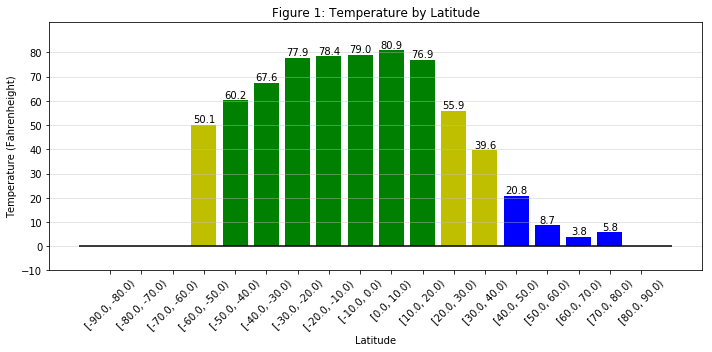

In [17]:
# Generate the plot
fig, ax = plt.subplots(figsize=(10,5))

# Generate bars by iterating through each bin
for ci in c_lat_df.index:

    # Set color bars based upon temperature
    c_temp = c_lat_df.loc[ci,'Temp']
    
    # If temperature is not populated for this bin,
    #  continue to move to the next bin
    if math.isnan(c_temp):
        continue
    
    # Pick the bar color based upon temperature
    if c_temp >= 95.0:
        c_color = 'r'

    elif c_temp >= 60.0:
        c_color = 'g'
        
    elif c_temp >= 32.0:
        c_color = 'y'
        
    else:
        c_color = 'b'
    
    # Set the placement location for the value text
    c_textloc = c_temp + 1
    
    # Get the value associated with this bar
    c_valuetext = f"{c_temp:.1f}"
        
    # Plot a bar
    plt.bar(ci, c_temp, color=c_color)
    
    # Place the value on this bar
    plt.text(ci, c_textloc, c_valuetext , ha='center')

plt.xticks(range(len(c_lat_df.index)), c_lat_df['Latitude Bin'], rotation=45)

# Set the y access limits to add room for the value labels
y_bot = c_lat_df['Temp'].min()
y_top = c_lat_df['Temp'].max()
y_range = y_top-y_bot

y_bot -= y_range * 0.15
y_top += y_range * 0.15
plt.ylim( bottom=y_bot, top=y_top)

# Adjust the tick marks to be more granular
plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=10))

plt.xlabel("Latitude")
plt.ylabel("Temperature (Fahrenheight)")
plt.title("Figure 1: Temperature by Latitude")

plt.grid(True, axis='y', color='0.75', alpha=0.5)
# plt.legend(loc="best")

# Add a horizontal line at the y = 0% level
plt.hlines(y=0, xmin=-1, xmax=len(c_lat_df.index))

plt.tight_layout()
plt.show()

In [18]:
# Save the Figure
fig.savefig("Results/temp_by_latitude.png")

#### Latitude vs. Humidity Plot

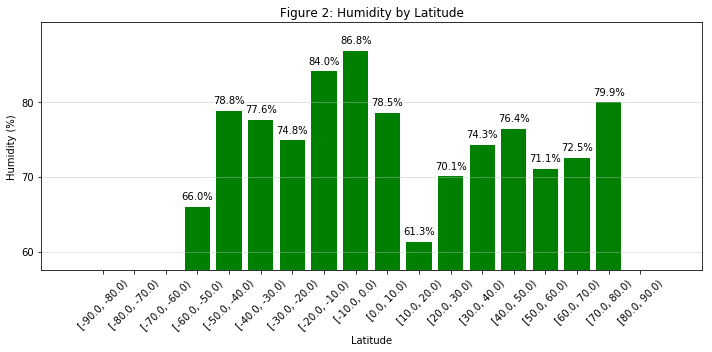

In [19]:
# Generate the plot
fig, ax = plt.subplots(figsize=(10,5))

# Generate bars by iterating through each bin
for ci in c_lat_df.index:

    # Set color bars based upon humidity
    c_humid = c_lat_df.loc[ci,'Humidity']
    
    # If humidity is not populated for this bin,
    #  continue to move to the next bin
    if math.isnan(c_humid):
        continue
    
    # Pick the bar color based upon humidity
    if c_humid >= 90.0:
        c_color = 'r'

    elif c_humid >= 60.0:
        c_color = 'g'
        
    elif c_humid >= 20.0:
        c_color = 'y'
        
    else:
        c_color = 'b'
    
    # Set the placement location for the value text
    c_textloc = c_humid + 1
    
    # Get the value associated with this bar
    c_valuetext = f"{c_humid:.1f}%"
        
    # Plot a bar
    plt.bar(ci, c_humid, color=c_color)
    
    # Place the value on this bar
    plt.text(ci, c_textloc, c_valuetext , ha='center')

plt.xticks(range(len(c_lat_df.index)), c_lat_df['Latitude Bin'], rotation=45)

# Set the y access limits to add room for the value labels
y_bot = c_lat_df['Humidity'].min()
y_top = c_lat_df['Humidity'].max()
y_range = y_top-y_bot

y_bot -= y_range * 0.15
y_top += y_range * 0.15
plt.ylim( bottom=y_bot, top=y_top)

# Adjust the tick marks to be more granular
plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=10))

plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title("Figure 2: Humidity by Latitude")

plt.grid(True, axis='y', color='0.75', alpha=0.5)
# plt.legend(loc="best")

# Add a horizontal line at the y = 0% level
plt.hlines(y=0, xmin=-1, xmax=len(c_lat_df.index))

plt.tight_layout()
plt.show()

In [20]:
# Save the Figure
fig.savefig("Results/humidity_by_latitude.png")

#### Latitude vs. Cloudiness Plot

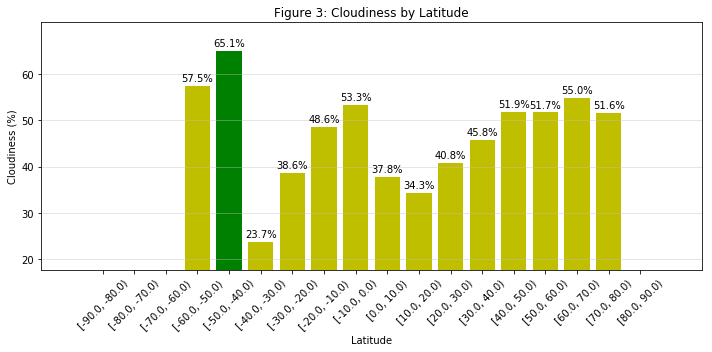

In [21]:
# Generate the plot
fig, ax = plt.subplots(figsize=(10,5))

# Generate bars by iterating through each bin
for ci in c_lat_df.index:

    # Set color bars based upon cloudiness
    c_cloud = c_lat_df.loc[ci,'Cloudiness']
    
    # If humidity is not populated for this bin,
    #  continue to move to the next bin
    if math.isnan(c_cloud):
        continue
    
    # Pick the bar color based upon cloudiness
    if c_cloud >= 90.0:
        c_color = 'r'

    elif c_cloud >= 60.0:
        c_color = 'g'
        
    elif c_cloud >= 20.0:
        c_color = 'y'
        
    else:
        c_color = 'b'
    
    # Set the placement location for the value text
    c_textloc = c_cloud + 1
    
    # Get the value associated with this bar
    c_valuetext = f"{c_cloud:.1f}%"
        
    # Plot a bar
    plt.bar(ci, c_cloud, color=c_color)
    
    # Place the value on this bar
    plt.text(ci, c_textloc, c_valuetext , ha='center')

plt.xticks(range(len(c_lat_df.index)), c_lat_df['Latitude Bin'], rotation=45)

# Set the y access limits to add room for the value labels
y_bot = c_lat_df['Cloudiness'].min()
y_top = c_lat_df['Cloudiness'].max()
y_range = y_top-y_bot

y_bot -= y_range * 0.15
y_top += y_range * 0.15
plt.ylim( bottom=y_bot, top=y_top)

# Adjust the tick marks to be more granular
plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=10))

plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title("Figure 3: Cloudiness by Latitude")

plt.grid(True, axis='y', color='0.75', alpha=0.5)
# plt.legend(loc="best")

# Add a horizontal line at the y = 0% level
plt.hlines(y=0, xmin=-1, xmax=len(c_lat_df.index))

plt.tight_layout()
plt.show()

In [22]:
# Save the Figure
fig.savefig("Results/cloud_by_latitude.png")

#### Latitude vs. Wind Speed Plot

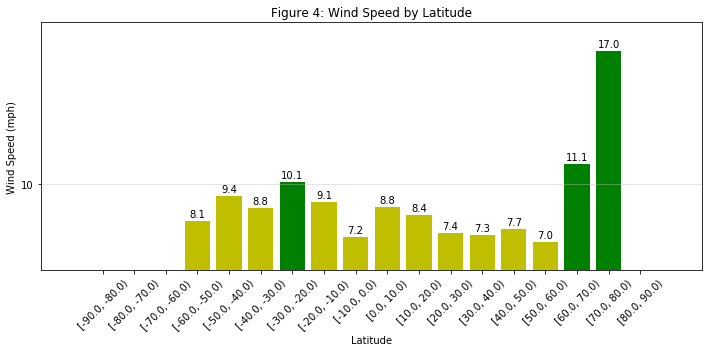

In [23]:
# Generate the plot
fig, ax = plt.subplots(figsize=(10,5))

# Generate bars by iterating through each bin
for ci in c_lat_df.index:

    # Set color bars based upon wind speed
    c_wind_speed = c_lat_df.loc[ci,'Wind Speed']
    
    # If humidity is not populated for this bin,
    #  continue to move to the next bin
    if math.isnan(c_wind_speed):
        continue
    
    # Pick the bar color based upon wind speed
    if c_wind_speed >= 20.0:
        c_color = 'r'

    elif c_wind_speed >= 10.0:
        c_color = 'g'
        
    elif c_wind_speed >= 5.0:
        c_color = 'y'
        
    else:
        c_color = 'b'
    
    # Set the placement location for the value text
    c_textloc = c_wind_speed + 0.2
    
    # Get the value associated with this bar
    c_valuetext = f"{c_wind_speed:.1f}"
        
    # Plot a bar
    plt.bar(ci, c_wind_speed, color=c_color)
    
    # Place the value on this bar
    plt.text(ci, c_textloc, c_valuetext , ha='center')

plt.xticks(range(len(c_lat_df.index)), c_lat_df['Latitude Bin'], rotation=45)

# Set the y access limits to add room for the value labels
y_bot = c_lat_df['Wind Speed'].min()
y_top = c_lat_df['Wind Speed'].max()
y_range = y_top-y_bot

y_bot -= y_range * 0.15
y_top += y_range * 0.15
plt.ylim( bottom=y_bot, top=y_top)

# Adjust the tick marks to be more granular
plt.yticks(np.arange(round(y_bot,-1),round(y_top,-1),step=10))

plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("Figure 4: Wind Speed by Latitude")

plt.grid(True, axis='y', color='0.75', alpha=0.5)
# plt.legend(loc="best")

# Add a horizontal line at the y = 0% level
plt.hlines(y=0, xmin=-1, xmax=len(c_lat_df.index))

plt.tight_layout()
plt.show()

In [24]:
# Save the Figure
fig.savefig("Results/wind_speed_by_latitude.png")